In [2]:
import pandas as pd
import scipy.optimize as opt
import regularized_optimization as reg_opt
import Utilityfunctions as utils
import jax.numpy as jnp
import numpy as np
import jax as jax
import matplotlib.pyplot as plt
import PyComplexHeatmap as pyc
import ssr_likelihood_jax as lik
jax.config.update("jax_enable_x64", True)

In [2]:
#mut_handle = "../data/paad/G12_PAADPANET_PM_z10_EventsAEP.csv"
#mut_handle = "../data/paad/G12_PAADPANET_PM_z10_Events_Mut50_Full.csv"
mut_handle = "../data/paad/G12_PAADPANET_PM_z10_Events_30and5_Full.csv"
annot_handle = "../data/paad/sampleSelection.txt"
#mut_handle = "../data/luad/G13_LUAD_PM_z1_Events_20and8_Full.csv"
#annot_handle = "../data/luad/G13_LUAD_PM_z1_sampleSelection_20and8.csv"
annot_data = pd.read_csv(annot_handle, sep="\t")
mut_data = pd.read_csv(mut_handle)
mut_data.rename(columns={"Unnamed: 0":"patientID"}, inplace = True)
dat = pd.merge(mut_data, annot_data.loc[:, ['patientID', 'metaStatus']], on=["patientID", "patientID"])

# Remove datapoints, that consist solely of NaNs
dat = dat.loc[dat.iloc[:,1:-3].isna().all(axis=1) == False, :]
dat = dat.loc[(dat.iloc[:,1:-3].sum(axis=1) > 0), :]
dat.columns

,P.Mut.KRAS,M.Mut.KRAS,P.Mut.TP53,M.Mut.TP53,P.gAEP033,M.gAEP033,P.chr18.del.single.1,M.chr18.del.single.1,P.chrX.del.single.1,M.chrX.del.single.1,...,P.Mut.SF3B1,M.Mut.SF3B1,P.Mut.STK11,M.Mut.STK11,P.Mut.PTPRT,M.Mut.PTPRT,paired,P.AgeAtSeqRep,M.AgeAtSeqRep,metaStatus
GENIE-MSK-P-0000142,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,52,No metastasis included,present
GENIE-MSK-P-0000314,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,42,No metastasis included,unknown
GENIE-MSK-P-0000421,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,No primary included,64,isMetastasis
GENIE-MSK-P-0000783,1,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,60,No metastasis included,present
GENIE-MSK-P-0000879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,No primary included,36,isMetastasis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GENIE-MSK-P-0065136,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,No metastasis included,unknown
GENIE-MSK-P-0065134,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,No metastasis included,unknown
GENIE-MSK-P-0067218,0,1,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,No primary included,NaN,isMetastasis
GENIE-MSK-P-0062309,0,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,No primary included,NaN,isMetastasis


In [3]:
start = 'P.Mut.KRAS'
stop = 'M.Mut.PTPRT'
mult = dat.set_index(["paired", "metaStatus"])
cleaned = mult.loc[zip(*[[0,0,0,1],["present", "absent", "isMetastasis", "isPaired"]]), start:stop]
cleaned = cleaned.sort_index()
cleaned.loc[(0, ["present", "isMetastasis"]), "Seeding"] = 1
cleaned.loc[(0, "absent"), "Seeding"] = 0
cleaned.loc[(1, "isPaired"), "Seeding"] = 1
events = cleaned.columns.to_list()[::2]
dat_prim_nomet, dat_met_only, dat_prim_met, dat_coupled = utils.split_data(cleaned)
print(dat_prim_nomet.shape[0], dat_prim_met.shape[0], dat_coupled.shape[0], dat_met_only.shape[0])

118 973 74 1022


In [4]:
n = (cleaned.shape[1]-1)//2
n += 1
lam1_start = np.log(3/87)
lam2_start = np.log(30/87) # observed mean time to second diagnosis is 87/162 days
indep = utils.indep(jnp.vstack((dat_met_only, dat_prim_met, dat_prim_nomet)), dat_coupled)
start_params = np.append(indep, [lam1_start, lam2_start])

In [ ]:
#utils.cross_val(cleaned, np.linspace(0.0001, 0.01, 5), 5, start_params, 0.6, n)

In [5]:
n_mod = n-1
arr = dat_coupled * np.array([1,2]*n_mod+[1])
arr = arr @ (np.diag([1,0]*n_mod+[1]) + np.diag([1,0]*n_mod, -1))
counts = np.zeros((7, n))
for i in range(0,2*n,2):
    i_h = int(i/2)
    for j in range(4):
        counts[j, i_h] = np.count_nonzero(arr[:,i]==j)/dat_coupled.shape[0]
    counts[4, i_h] = np.sum(dat_prim_nomet[:, i], axis=0)/dat_prim_nomet.shape[0]
    counts[5, i_h] = (np.sum(dat_prim_met[:, i], axis=0))/dat_prim_met.shape[0]
    counts[6, i_h] = (np.sum(dat_met_only[:, i+1], axis=0))/dat_met_only.shape[0]

labels = [["Coupled ("+str(dat_coupled.shape[0])+")"]*4 +\
          ["Prim_no_met ("+str(dat_prim_nomet.shape[0])+")"] +\
          ["Prim_met ("+str(dat_prim_met.shape[0])+")"] +["Met ("+str(dat_met_only.shape[0])+")"],
          ["absent", "present_prim", "present_met", "both"] + ["present"]*3]
       
inds =  pd.MultiIndex.from_tuples(list(zip(*labels)))
pd.DataFrame(np.around(counts, 2), columns=events, index=inds).T


Coupled (74)                                 \
                           absent present_prim present_met  both   
P.Mut.KRAS                   0.22         0.05        0.04  0.69   
P.Mut.TP53                   0.27         0.07        0.12  0.54   
P.gAEP033                    0.49         0.16        0.26  0.09   
P.chr18.del.single.1         0.62         0.14        0.18  0.07   
P.chrX.del.single.1          0.72         0.11        0.12  0.05   
P.Mut.SMAD4                  0.73         0.04        0.04  0.19   
P.chr20.amp.single.1         0.64         0.15        0.11  0.11   
P.chr17.del.single.1         0.76         0.08        0.14  0.03   
P.Mut.CDKN2A                 0.82         0.01        0.05  0.11   
P.Mut.ARID1A                 0.88         0.01        0.04  0.07   
P.Mut.RNF43                  0.95         0.00        0.00  0.05   
P.Mut.MEN1                   0.91         0.00        0.00  0.09   
P.Mut.TGFBR2                 0.99         0.00        0.01  0.00   
P.Mut.KDM6A                  1.00         0.00        0.00  0.00   
P.Mut.KMT2D                  0.97         0.00        0.01  0.01   
P.Mut.GNAS                   0.97         0.00        0.01  0.01   
P.Mut.DAXX                   0.86         0.00        0.04  0.09   
P.Mut.KMT2C                  0.95         0.00        0.01  0.04   
P.Mut.ATM                    0.95         0.00        0.01  0.04   
P.Mut.RBM10                  1.00         0.00        0.00  0.00   
P.Mut.BRCA2                  0.95         0.00        0.03  0.03   
P.Mut.SETD2                  0.95         0.00        0.04  0.01   
P.Mut.ATRX                   0.95         0.01        0.01  0.03   
P.Mut.PIK3CA                 1.00         0.00        0.00  0.00   
P.Mut.RB1                    0.99         0.00        0.00  0.01   
P.Mut.TGFBR1                 0.99         0.01        0.00  0.00   
P.Mut.SMARCA4                0.95         0.04        0.01  0.00   
P.Mut.SMAD3                  0.97         0.00        0.03  0.00   
P.Mut.MAP2K4                 0.99         0.00        0.00  0.01   
P.Mut.TSC2                   0.93         0.00        0.05  0.01   
P.Mut.BCOR                   1.00         0.00        0.00  0.00   
P.Mut.U2AF1                  0.97         0.01        0.01  0.00   
P.Mut.SF3B1                  0.99         0.00        0.00  0.01   
P.Mut.STK11                  1.00         0.00        0.00  0.00   
P.Mut.PTPRT                  0.99         0.00        0.01  0.00   
Seeding                      0.00         1.00        0.00  0.00   

                     Prim_no_met (118) Prim_met (973) Met (1022)  
                               present        present    present  
P.Mut.KRAS                        0.81           0.88       0.85  
P.Mut.TP53                        0.58           0.71       0.71  
P.gAEP033                         0.31           0.25       0.47  
P.chr18.del.single.1              0.33           0.27       0.40  
P.chrX.del.single.1               0.18           0.15       0.28  
P.Mut.SMAD4                       0.21           0.20       0.19  
P.chr20.amp.single.1              0.16           0.17       0.24  
P.chr17.del.single.1              0.16           0.15       0.27  
P.Mut.CDKN2A                      0.15           0.10       0.14  
P.Mut.ARID1A                      0.08           0.08       0.09  
P.Mut.RNF43                       0.06           0.05       0.05  
P.Mut.MEN1                        0.08           0.04       0.04  
P.Mut.TGFBR2                      0.05           0.04       0.03  
P.Mut.KDM6A                       0.03           0.04       0.04  
P.Mut.KMT2D                       0.05           0.02       0.04  
P.Mut.GNAS                        0.05           0.04       0.02  
P.Mut.DAXX                        0.01           0.02       0.03  
P.Mut.KMT2C                       0.03           0.03       0.02  
P.Mut.ATM                         0.01           0.02       0.03  
P.Mut.RBM10                  

In [10]:
penal1 = 0.008
penal2 = 0.003
m_p_corr = 0.8
x = opt.minimize(reg_opt.value_grad, x0 = start_params, args = (dat_prim_nomet, dat_coupled, dat_prim_met, dat_met_only, n-1, penal1, penal2,  m_p_corr), 
                method = "L-BFGS-B", jac = True, options={"maxiter":10000, "disp":True, "ftol":1e-05})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1298     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53219D+01    |proj g|=  9.74710D-01


 This problem is unconstrained.



At iterate    1    f=  1.38967D+01    |proj g|=  9.45234D-01

At iterate    2    f=  1.14196D+01    |proj g|=  5.41571D-01

At iterate    3    f=  1.09293D+01    |proj g|=  6.64866D-02

At iterate    4    f=  1.08271D+01    |proj g|=  1.43677D-01

At iterate    5    f=  1.06466D+01    |proj g|=  1.46749D-01

At iterate    6    f=  1.02600D+01    |proj g|=  1.05414D-01

At iterate    7    f=  1.02378D+01    |proj g|=  1.00366D-01

At iterate    8    f=  1.00864D+01    |proj g|=  3.38165D-02

At iterate    9    f=  1.00615D+01    |proj g|=  5.50304D-02

At iterate   10    f=  9.98369D+00    |proj g|=  2.16825D-02

At iterate   11    f=  9.93418D+00    |proj g|=  3.25075D-02

At iterate   12    f=  9.88270D+00    |proj g|=  2.54817D-02

At iterate   13    f=  9.84591D+00    |proj g|=  2.71714D-02

At iterate   14    f=  9.81032D+00    |proj g|=  2.42920D-02

At iterate   15    f=  9.78737D+00    |proj g|=  1.43492D-02

At iterate   16    f=  9.75878D+00    |proj g|=  1.40689D-02

At iter

In [8]:
print(1/jnp.exp(x.x[-2]))
df2 = pd.DataFrame(x.x[:-2].reshape((n, n)), columns=events, index=events)
df = df2.copy()
df2["Sampling"] = np.append(np.array(x.x[-2:]), np.zeros(n-2))
df2.to_csv("../results/luad/luad_" + "mixed_06_0035" + ".csv")
df2.round(3)

7.542882762677719


,P.Mut.KRAS,P.Mut.TP53,P.gAEP033,P.chr18.del.single.1,P.chrX.del.single.1,P.Mut.SMAD4,P.chr20.amp.single.1,P.chr17.del.single.1,P.Mut.CDKN2A,P.Mut.ARID1A,...,P.Mut.SMAD3,P.Mut.MAP2K4,P.Mut.TSC2,P.Mut.BCOR,P.Mut.U2AF1,P.Mut.SF3B1,P.Mut.STK11,P.Mut.PTPRT,Seeding,Sampling
P.Mut.KRAS,-0.483,-2.271,-1.270,-0.049,-0.005,0.003,-1.578,0.000,-0.007,0.004,...,0.000,0.002,-0.020,-0.006,0.003,0.002,0.001,-0.000,-0.991,-2.021
P.Mut.TP53,3.187,-3.899,-0.034,-1.028,-0.002,-0.571,-0.004,0.001,0.578,0.000,...,-0.108,-1.430,0.002,-0.001,-0.001,-0.865,-0.002,0.001,-0.275,-1.065
P.gAEP033,-0.147,0.001,-3.948,-0.033,0.784,0.001,2.310,3.052,-0.002,-0.001,...,0.000,-0.000,0.000,0.001,0.000,-0.001,0.001,-0.001,0.377,0.000
P.chr18.del.single.1,0.913,0.003,3.505,-4.545,-0.850,-0.004,-0.717,-0.000,0.019,-0.004,...,0.000,0.002,-0.001,-0.001,0.126,0.003,-0.001,-0.000,-0.407,0.000
P.chrX.del.single.1,-0.001,-0.000,0.078,2.082,-4.419,-0.002,0.148,-0.083,0.001,0.000,...,0.006,-0.005,0.001,-0.002,-0.002,-0.003,-0.000,-0.000,-0.001,0.000
P.Mut.SMAD4,1.785,-0.473,-0.002,-0.006,-1.062,-4.482,-0.007,-0.001,0.046,0.007,...,-0.000,-0.002,-0.000,-0.001,-0.001,-0.003,-0.001,-0.001,-0.838,0.000
P.chr20.amp.single.1,-0.001,-0.165,-1.112,0.001,0.005,-0.054,-3.460,0.004,-0.002,-0.104,...,-0.001,0.013,-0.003,-0.000,-0.000,-0.001,-0.002,-0.001,-0.164,0.000
P.chr17.del.single.1,0.652,0.232,0.164,1.206,0.004,-0.013,0.004,-4.757,-0.117,-0.678,...,-0.002,0.005,0.000,-0.001,-0.001,-0.001,0.002,-0.001,0.224,0.000
P.Mut.CDKN2A,0.663,0.004,-0.114,-0.065,-0.005,-0.001,-0.011,-0.001,-4.528,-0.001,...,0.002,-0.001,-0.002,0.001,-0.001,-0.001,-0.001,-0.001,-0.229,0.000
P.Mut.ARID1A,-0.355,-0.838,-0.001,-0.001,0.000,-0.001,-0.662,-0.010,-0.000,-4.072,...,0.002,-0.000,-0.001,0.001,-0.001,-0.001,-0.001,0.000,-0.042,0.000


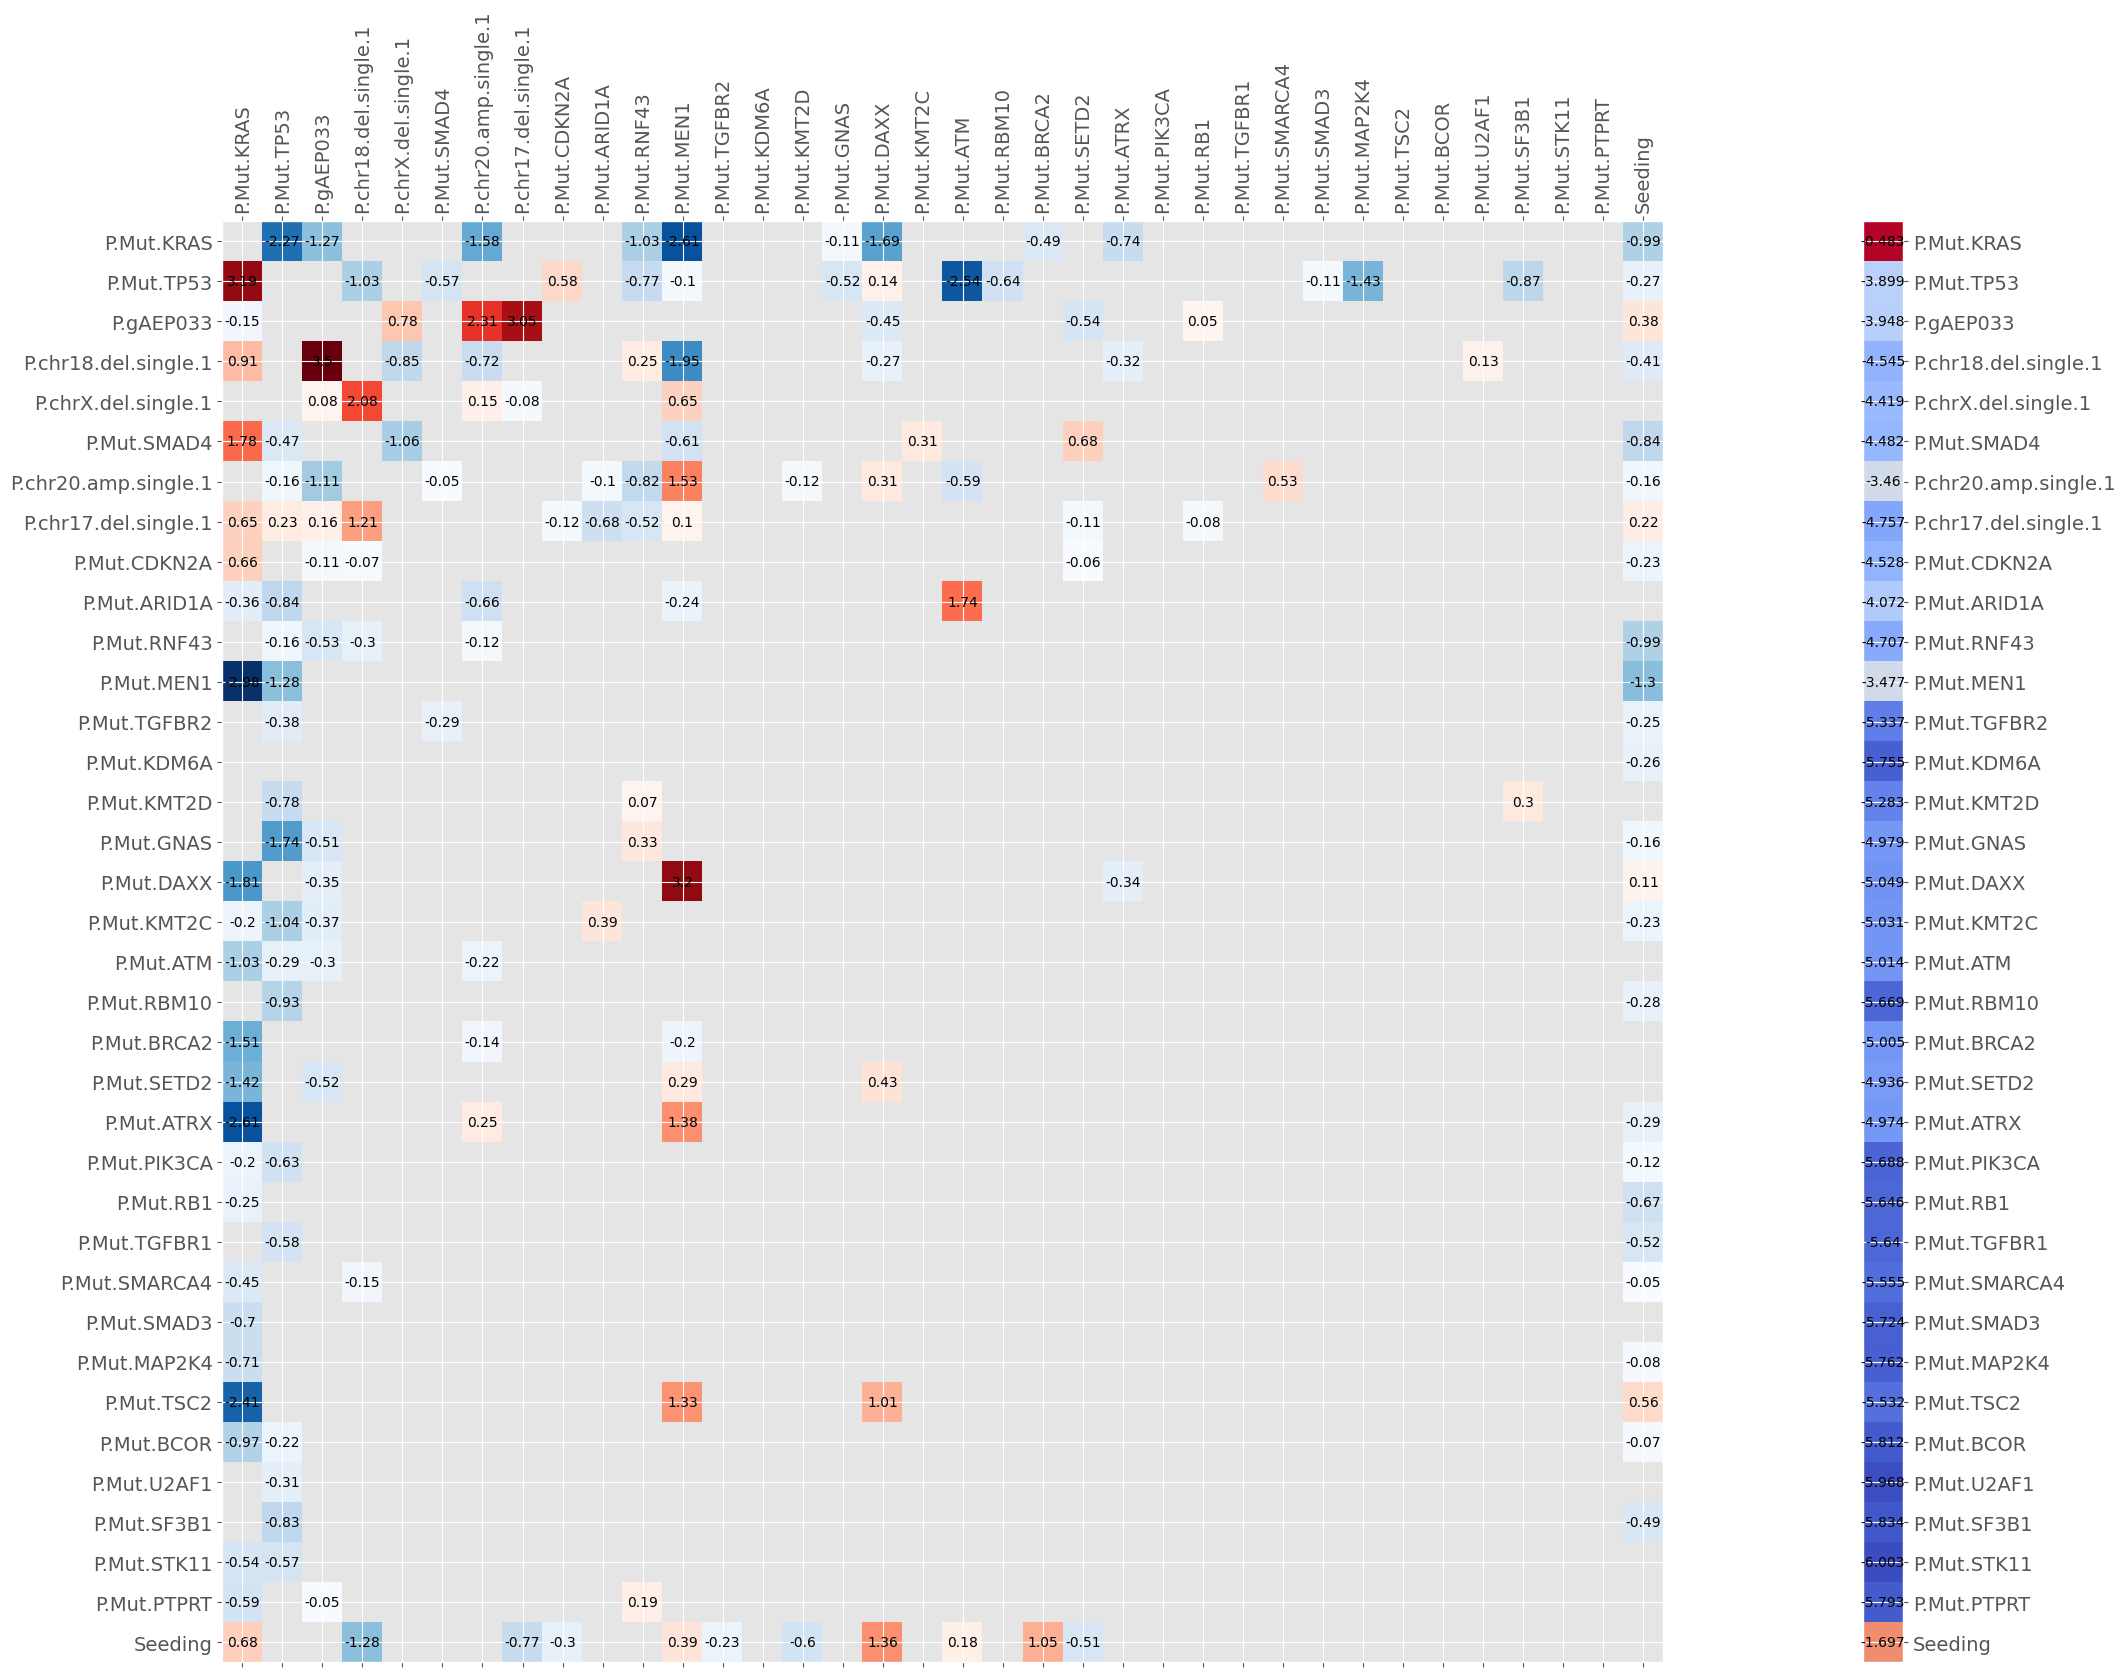

In [9]:
df[(df.round(2) == 0) | (df.round(2) == -0)] = np.nan
theta_diag = np.diag(df.copy()).reshape((-1,1))
df[df.abs() <= 0.05] = np.nan
np.fill_diagonal(df.values, np.nan)

plt.style.use("ggplot")
f, (ax, ax2) = plt.subplots(1, 2, figsize=(19,15), gridspec_kw={'width_ratios': [6, 1]})
f.tight_layout()
ax.matshow(df[df<0], cmap="Blues_r")
ax.matshow(df[df>0], cmap="Reds")
ax2.matshow(theta_diag, cmap="coolwarm")
ax.set_xticks(range(df.shape[1]), events, fontsize=14, rotation=90)
ax.set_yticks(range(df.shape[1]), events, fontsize=14)
ax2.set_yticks(range(df.shape[1]), events, fontsize=14)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xticks([])

for i in range(n):
    for j in range(n):
        if np.isnan(df.iloc[i,j]) == False:
            c = np.round(df.iloc[i,j].round(2), 2)
        else:
            c = ""
        ax.text(j, i, str(c), va='center', ha='center')
    ax2.text(0, i, np.round(theta_diag[i,0],3), va='center', ha='center')
plt.show()

In [ ]:
theta = pd.read_csv("../results/luad/luad_" + "mixed_06_0035" + ".csv", index_col=0)
theta

In [ ]:
th = jnp.array(df2.iloc[:-1,:].to_numpy())
th = th.at[:-1,-1].set(0.)
lam1 = jnp.exp(df2.iloc[0, -1])
p_seeded = jnp.zeros(dat_prim_met.shape[0])
for i in range(dat_prim_met.shape[0]):
    p_seeded = p_seeded.at[i].set(lik.prob_seeded(th, dat_prim_met.at[i,:].get(), lam1))

plt.boxplot(p_seeded)